# Flows From V4
(powered by v4)

V4 brings a complete revision and expansion of the whole CargoTracking module to serve all commodity tracking needs at vessel-per-vessel level.
* Quantity estimated at event level (so for each StS operation and load/discharge) in addition to the voyage level and for Tanker, provided both in tonnes and in barrels. 
    * More accurate flows that go beyond the FirstLoad/LastDischarge approximation.
* More cargo fields from the Cargo Grade level up to the Cargo Group one. 
* A source for each cargo to specify what market data backed that cargo up.
* Confidence levels about our model estimation (High/Medium/Low).

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/FlowsFromV4.ipynb). 

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
!pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

## Call the Voyages API
The Voyages API retrieves information about vessel voyages.

In [2]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
import pandas as pd
from datetime import datetime
import plotly.express as px

In [3]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

## Example 1, Tankers: VLCC Crude flows from US to China (at Port Call level, powered by V4)

Get vessel class id for VLCCs

In [4]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Tanker'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
11,84,VLCC,1,Tanker
12,85,Suezmax,1,Tanker
13,86,Aframax,1,Tanker
14,87,Panamax,1,Tanker
15,88,MR2,1,Tanker
16,89,MR1,1,Tanker
17,90,Small,1,Tanker


### Get voyages for VLCCs

We will use vessel_class_id = 84 as above when calling the API

In [5]:
voyages = api.get_voyages(vessel_class_id=84, date_from=datetime.strptime("2021-09-01", "%Y-%m-%d"))
voyages = pd.DataFrame([v.__dict__ for v in voyages])
voyages.tail(2)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,is_implied_by_ais,has_manual_entries,ballast_distance,predicted_ballast_distance,laden_distance,predicted_laden_distance,suez_crossing,panama_crossing,canakkale_crossing,bosporus_crossing
10358,9943748,4,1,84,1,558.0,False,"(VoyageEvent(id='I97BAC454SEDD103100', port_id...",I97BAC454VEDD103100,2,...,None,None,6151.11,NaN,6195.45,385.69,None,None,None,None
10359,9946673,1,1,84,1,1441.0,False,"(VoyageEvent(id='I97C63154SEDB84AF00', port_id...",I97C63154VEDB84AF00,2,...,None,None,5266.17,NaN,NaN,NaN,None,None,None,None


Keep only historical voyages and drop some columns
* **Note 1:** Voyages Data API has information on all levels of the Cargo Tree taxonomy, from cargo group down to cargo sub type (grade). For this first example we will use cargo_sub_group that is the corresponding taxonomy of Crude
* **Note 2:** Voyages Data API also provides quantity in barrels that we will use in this example

In [6]:
voyages = voyages[voyages['horizon']=='Historical'][['id', 'quantity_in_barrels', 'cargo_sub_group', 'events']].copy()
voyages.rename(columns={'quantity_in_barrels': 'voyage_quantity_in_barrels', 'id': 'v_id'}, inplace = True)

explode dataframe to create 1 row per event and extract event info into columns

In [7]:
voyages=voyages.explode('events')
voyages['events'] = voyages['events'].apply(lambda x: x.__dict__)
voyages=pd.concat([voyages.drop(['events'], axis=1), voyages['events'].apply(pd.Series)], axis=1)

Keep only Load/Discharge events and drop some columns

In [8]:
voyages=voyages[(voyages['purpose']=='Discharge')|(voyages['purpose']=='Load')][[ 'v_id', 'voyage_quantity_in_barrels', 'cargo_sub_group', 
                                                                                 'purpose', 'arrival_date', 'sailing_date', 'port_name', 
                                                                                 'country', 'quantity', 'quantity_in_barrels']]

### Converting events to flows

Combine Load and Discharge operations of the same voyage to create flows

In [9]:
flows=voyages[voyages['purpose']=='Load'].merge(voyages[voyages['purpose']=='Discharge'], on = ['v_id', 'voyage_quantity_in_barrels', 'cargo_sub_group'], suffixes=['_load','_discharge'])

Calculate quantity for each elementary flow

In [10]:
flows['flow_quantity_in_barrels'] = flows['quantity_in_barrels_load']*flows['quantity_in_barrels_discharge']/flows['voyage_quantity_in_barrels']

Convert Timestamp to datetime

In [11]:
flows['sailing_date_load'] = flows['sailing_date_load'].apply(lambda d : pd.to_datetime(d).tz_localize(None))

### Group flows by origin country and destination, and use sailing_date_load as date of export

In [12]:
US_China_crude = flows[(flows['sailing_date_load']>"2022-01-01")&(flows['cargo_sub_group']=='Crude')] \
    .set_index('sailing_date_load') \
    .groupby(['country_load', 'country_discharge'])['flow_quantity_in_barrels'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'sailing_date_load': 'Date'})

* Keep only US to China flows

In [13]:
US_China_crude = US_China_crude[(US_China_crude['country_load']=='United States')&(US_China_crude['country_discharge']=='China')]

* Aggregate all exports monthly
* Drop unnecessary columns 

In [14]:
US_China_crude['TotalExports'] = US_China_crude['flow_quantity_in_barrels'].groupby(US_China_crude['Date']).transform('sum')
US_China_crude.drop_duplicates(subset=['Date'], keep='last', inplace = True)
US_China_crude.drop(['country_discharge', 'flow_quantity_in_barrels'], axis=1, inplace = True)
US_China_crude.head()

,country_load,Date,TotalExports
4443,United States,2022-01-01,5516656.0
4444,United States,2022-02-01,3801507.0
4445,United States,2022-03-01,8482108.0
4446,United States,2022-04-01,6956842.0
4447,United States,2022-05-01,1830122.0


### Plot the flows

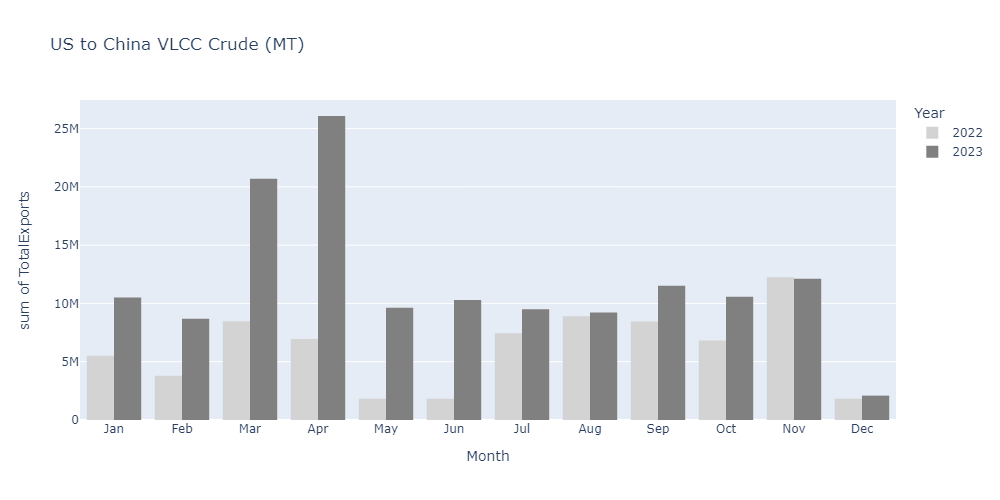

In [15]:
US_China_crude['Year'] = US_China_crude['Date'].apply(lambda date : date.year)
US_China_crude['Month'] = US_China_crude['Date'].apply(lambda date : date.month)
US_China_crude.sort_values(['Month', 'Year'], inplace = True)
US_China_crude['Month'] = US_China_crude['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(US_China_crude, x="Month", y="TotalExports", color='Year',
             barmode='group', height=500, width=1000,
             title='US to China VLCC Crude (MT)',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Example 2 - Dry: Panamaxes Thermal Coal Flows from Newcastle to Japan (at Port Call level, powered by V4)

Extract vessel class ids for Panamaxes

In [16]:
vessel_classes_df[vessel_classes_df['vessel_type']=='Dry'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
4,69,VLOC,3,Dry
5,70,Capesize,3,Dry
6,72,Post Panamax,3,Dry
7,74,Panamax,3,Dry
8,75,Supramax,3,Dry
9,76,Handymax,3,Dry
10,77,Handysize,3,Dry
19,92,Small,3,Dry


### Get voyages for selected vessel classes (Post Panamax and Panamax) after a given date

In [17]:
vessel_class_ids = (72, 74)
date_from = datetime.strptime("2022-09-01", "%Y-%m-%d")

voyages = []
for vessel_class_id in vessel_class_ids:    
    voyages.append(api.get_voyages(vessel_class_id=vessel_class_id, date_from=date_from))

voyages = pd.DataFrame([v.__dict__ for vc in voyages for v in vc])
voyages.tail(2)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,is_implied_by_ais,has_manual_entries,ballast_distance,predicted_ballast_distance,laden_distance,predicted_laden_distance,suez_crossing,panama_crossing,canakkale_crossing,bosporus_crossing
34619,9991680,2,3,74,1,NaN,False,"(VoyageEvent(id='I9876004ASEDD37BE00', port_id...",I9876004AVEDD37BE00,1,...,None,None,780.03,NaN,791.47,NaN,None,None,None,None
34620,9991680,3,3,74,1,NaN,False,"(VoyageEvent(id='I9876004ASEDD521C00', port_id...",I9876004AVEDD521C00,2,...,True,None,175.35,571.09,NaN,1419.93,None,None,None,None


Keep only voyages with Cargo Type Thermal Coal

In [18]:
voyages = voyages[(voyages['horizon']=='Historical')&(voyages['cargo_type']=='Thermal Coal')][['id', 'quantity', 'cargo_type', 'events']].copy()
voyages.rename(columns={'quantity': 'voyage_quantity', 'id': 'v_id'}, inplace = True)

explode dataframe to create 1 row per event and extract event info into columns

In [19]:
voyages=voyages.explode('events')
voyages['events'] = voyages['events'].apply(lambda x: x.__dict__)
voyages=pd.concat([voyages.drop(['events'], axis=1), voyages['events'].apply(pd.Series)], axis=1)

Keep only Load/Discharge events and drop some columns
* **Note:** Voyages Data API has information on all levels of Cargo Tree taxonomy, from cargo group, down to cargo sub type (grade). For this example we will use cargo_type corresponding to the taxonomy of Thermal Coal

In [20]:
voyages=voyages[(voyages['purpose']=='Discharge')|(voyages['purpose']=='Load')][[ 'v_id', 'voyage_quantity', 'purpose', 'arrival_date', 'cargo_type',
                                                                                 'sailing_date', 'port_name', 'country', 'quantity']]

### Converting events to flows

Combine Load and Discharge operations of the same voyage to create flows

In [21]:
flows=voyages[voyages['purpose']=='Load'].merge(voyages[voyages['purpose']=='Discharge'], on = ['v_id', 'voyage_quantity', 'cargo_type'], suffixes=['_load','_discharge'])

In [22]:
flows['flow_quantity'] = flows['quantity_load']*flows['quantity_discharge']/flows['voyage_quantity']

Convert Timestamp to datetime

In [23]:
flows['sailing_date_load'] = flows['sailing_date_load'].apply(lambda d : pd.to_datetime(d).tz_localize(None))

## Group flows by origin port and destination country and use sailing_date_load as date of export

In [24]:
Newcastle_Japan_coal = flows[(flows['sailing_date_load']>"2023-01-01")] \
    .set_index('sailing_date_load') \
    .groupby(['port_name_load', 'country_discharge'])['flow_quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'sailing_date_load': 'Date'})

* Keep only Newcastle to Japan flows

In [25]:
Newcastle_Japan_coal = Newcastle_Japan_coal[(Newcastle_Japan_coal['port_name_load']=='Newcastle')&(Newcastle_Japan_coal['country_discharge']=='Japan')]

* Aggregate all exports monthly
* Drop unnecessary columns 

In [26]:
Newcastle_Japan_coal['TotalExports'] = Newcastle_Japan_coal['flow_quantity'].groupby(Newcastle_Japan_coal['Date']).transform('sum')
Newcastle_Japan_coal.drop_duplicates(subset=['Date'], keep='last', inplace = True)
Newcastle_Japan_coal.drop(['country_discharge', 'flow_quantity'], axis=1, inplace = True)
Newcastle_Japan_coal.head()

,port_name_load,Date,TotalExports
1950,Newcastle,2023-01-01,4407000.0
1951,Newcastle,2023-02-01,3623000.0
1952,Newcastle,2023-03-01,4003000.0
1953,Newcastle,2023-04-01,1959000.0
1954,Newcastle,2023-05-01,2703000.0


### Plot the flows

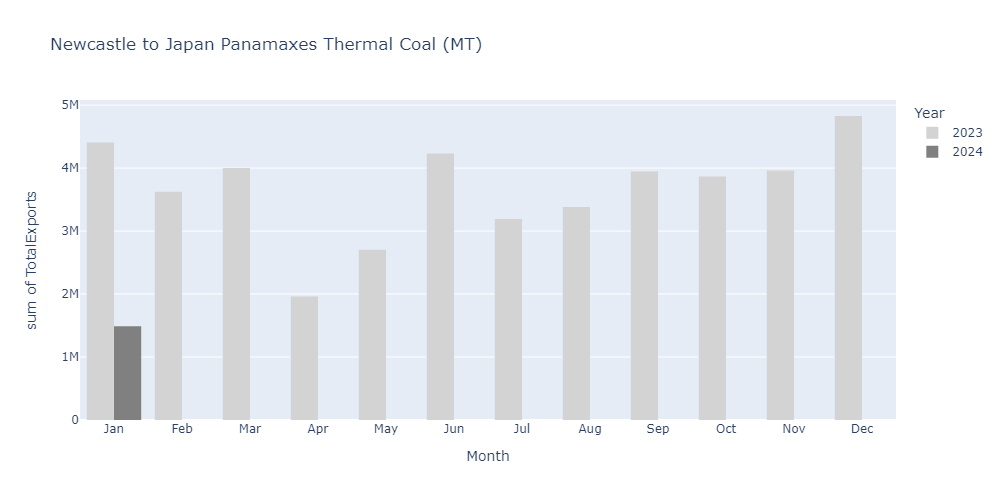

In [27]:
Newcastle_Japan_coal['Year'] = Newcastle_Japan_coal['Date'].apply(lambda date : date.year)
Newcastle_Japan_coal['Month'] = Newcastle_Japan_coal['Date'].apply(lambda date : date.month)
Newcastle_Japan_coal.sort_values(['Month', 'Year'], inplace = True)
Newcastle_Japan_coal['Month'] = Newcastle_Japan_coal['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(Newcastle_Japan_coal, x="Month", y="TotalExports", color='Year',
             barmode='group', height=500, width=1000,
             title='Newcastle to Japan Panamaxes Thermal Coal (MT)',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()